# Time Series and Linear Regression

- Forecasting could be done using <b>time-series</b> or <b>regression</b>.
    - Time Series uses past values to determine future values
        - Could be a simple linear regression with one past value
        - Could be an ARIMA 'official' time series model (Auto Regressive Integrated Moving Average) - describe how each successive value in a series is related to previous values
    - Regression uses variables / covariates to determine future values
- Time series are sequences of snapshots of processes, evenly spaced
    - The daily closing value of stocks are time-series

In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

plt.rc('figure', figsize=(12, 8.0))

# Import Data

- AAPL_10y.csv Apple data from 01/08/2011 to 01/08/2021
- AMZN_10y.csv Amazon data from 01/08/2011 to 01/08/2021
- FB_10y.csv Facebook data from 01/08/2011 to 01/08/2021

In [2]:
df_aapl = pd.read_csv('AAPL_10y.csv')

In [3]:
#Check for null values
df_aapl.isnull().sum() 

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [4]:
df_aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-08-01,14.206429,14.267857,14.013214,14.169643,12.166288,612836000
1,2011-08-02,14.201786,14.210714,13.869643,13.889643,11.925877,639539600
2,2011-08-03,13.963571,14.055357,13.651429,14.020357,12.038110,732508000
3,2011-08-04,13.907500,13.975714,13.476786,13.477500,11.572001,871407600
4,2011-08-05,13.587143,13.696429,12.948929,13.343571,11.457007,1204590800


In [5]:
df_aapl = df_aapl[['Date', 'Close']].copy()

In [6]:
df_aapl.head()

,Date,Close
0,2011-08-01,14.169643
1,2011-08-02,13.889643
2,2011-08-03,14.020357
3,2011-08-04,13.477500
4,2011-08-05,13.343571


## Exploratory Data Analysis

In [7]:
# Find the min and max Date of our data
print('Min Date:' ,min(df_aapl['Date']))
print('Max Date:' ,max(df_aapl['Date']))

Min Date: 2011-08-01
Max Date: 2021-07-30


### Calculate Average closing share price for each year

- Use the `pd.DatetimeIndex(df['Date']).year` method and store this as 'Year' column

In [8]:
import datetime

In [9]:
#Create separate column for year
df_aapl['Year'] = pd.DatetimeIndex(df_aapl['Date']).year
df_aapl['Year'].head()

0    2011
1    2011
2    2011
3    2011
4    2011
Name: Year, dtype: int64

In [10]:
df_aapl['Year'].value_counts().sort_index()

2011    107
2012    250
2013    252
2014    252
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    145
Name: Year, dtype: int64

<AxesSubplot:xlabel='Year'>

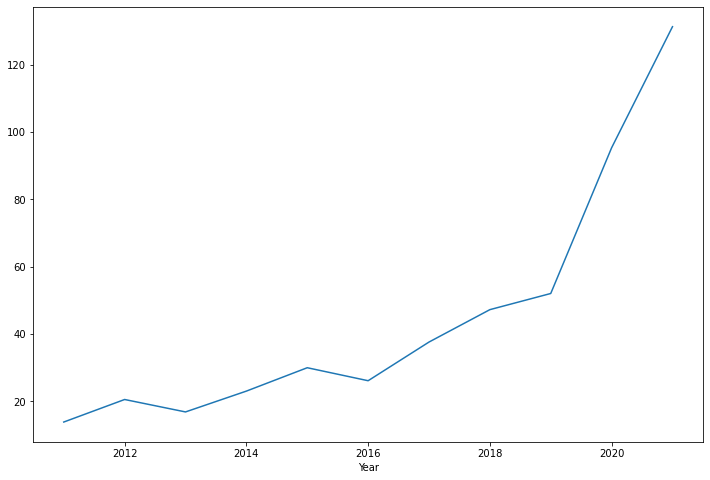

In [11]:
# Calculate Average 'Close' share price for each year (Groupby Year)
df_aapl.groupby('Year')['Close'].mean().sort_index().plot()

### Which 5 dates correspond to the greatest increase in AAPL stock?
- Output percent increase in previous day's closing price
- SQL would use `100 * Close / LAG(Close,1) OVER(ORDER BY Date) AS pct_close_change`
- We'll have to create lag variables!!

### Creating LAG variables

Modeling time series data can be challenging, because you must spend some time transforming your data to a format unique to time series models. This usually means transforming date columns into pandas datetime columns using `pd.to_datetime()` and calculating lagged variables, which help you determine how past values influence current and future values (auto-correlation). 

To generate lagged variables, here are some helpful methods:
- `.shift()`: Lag one or more variables across one group. Can be used with `.groupby()`
- `.unstack()`: Lag one variable across multiple groups.

In [12]:
df_aapl["Date"] = pd.to_datetime(df_aapl['Date'])

### Create Lagged `Close` values with `.shift()` 
- With only one series in your DataFrame, you can apply `.shift()` directly to the column of interest.
- To be more careful, you can set the `Date` column as the index and specify the number of steps (here, 1 “day”) to lag after we set the date column as an index. 
    - `df.set_index(["Date"]).shift(1)`
- NOTE: you can use a negative number as the shift, so that future values are influencing the past.

In [13]:
df_aapl['day_prev_close'] = df_aapl['Close'].shift(1)
df_aapl['min_2_close'] = df_aapl['Close'].shift(2)
df_aapl['min_3_close'] = df_aapl['Close'].shift(3)
df_aapl['min_4_close'] = df_aapl['Close'].shift(4)

In [14]:
# Take a look at the new columns you created -- there are NaN values for previous rows when expected, right?
df_aapl.head()

,Date,Close,Year,day_prev_close,min_2_close,min_3_close,min_4_close
0,2011-08-01,14.169643,2011,NaN,NaN,NaN,NaN
1,2011-08-02,13.889643,2011,14.169643,NaN,NaN,NaN
2,2011-08-03,14.020357,2011,13.889643,14.169643,NaN,NaN
3,2011-08-04,13.477500,2011,14.020357,13.889643,14.169643,NaN
4,2011-08-05,13.343571,2011,13.477500,14.020357,13.889643,14.169643


### Find the percentage change in closing value over previous day:
- Assign the resulting series to the column: 'pct_close_change'
- 100 * (df['Close']/df['day_prev_close'])

In [15]:
df_aapl['pct_close_change'] = 100* (df_aapl['Close']/df_aapl['day_prev_close'])
df_aapl['pct_close_change'].head()

0           NaN
1     98.023945
2    100.941090
3     96.128080
4     99.006277
Name: pct_close_change, dtype: float64

C:\Users\jitwkoh\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pct_close_change', ylabel='Density'>

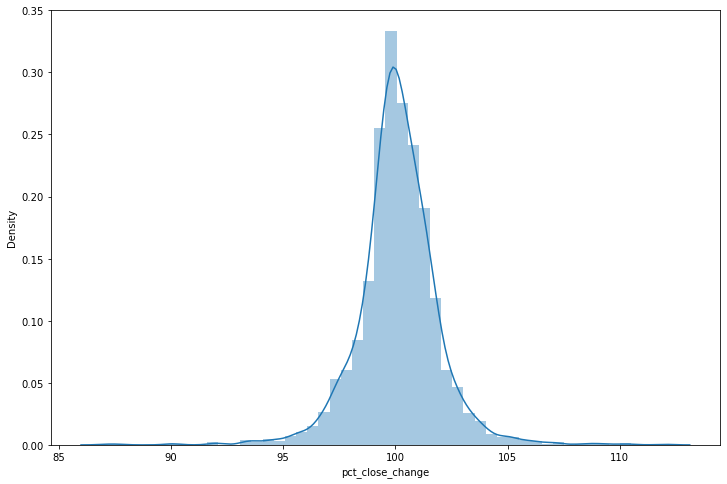

In [16]:
sns.distplot(df_aapl.pct_close_change.dropna())

### Lag one variable across multiple groups — using “unstack” method
- Use this when you have multiple groups/ stock prices, but only one variable to be lagged (`Close`). 
- NOTE OF CAUTION: We must index our data first, then unstack to separate the groups before applying the lag function. Otherwise the last value of the previous group will become the next value of the next group!
    - Set the index to be the date AND your groups.
    - Separate the groups using unstack
    - Apply `.shift()` to the variable you want to lag.

In [17]:
# Read in another stock time series
amzn = pd.read_csv('AMZN_10y.csv')
amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-08-01,225.000000,227.449997,217.660004,221.320007,221.320007,5789300
1,2011-08-02,220.320007,222.429993,211.300003,211.699997,211.699997,6586700
2,2011-08-03,212.970001,214.830002,205.539993,209.960007,209.960007,8197100
3,2011-08-04,206.729996,208.000000,201.449997,201.479996,201.479996,6579500
4,2011-08-05,204.669998,207.320007,194.839996,202.699997,202.699997,10024000


In [18]:
amzn = amzn[['Date', 'Close']].copy()

In [19]:
# Create a column that indicates what stock this is:
amzn['Symbol'] = 'AMZN'

In [20]:
df_aapl['Symbol'] = 'AAPL'

In [21]:
amzn['Date'] = pd.to_datetime(amzn['Date'])

In [22]:
# Concatenate the Date, symbol and close columns of the AAPL and AMZN data by row
group_df = pd.concat([df_aapl[['Date','Symbol', 'Close']], amzn[['Date', 'Symbol','Close']]], axis = 0)
group_df.head()

,Date,Symbol,Close
0,2011-08-01,AAPL,14.169643
1,2011-08-02,AAPL,13.889643
2,2011-08-03,AAPL,14.020357
3,2011-08-04,AAPL,13.477500
4,2011-08-05,AAPL,13.343571


In [23]:
group_df['Symbol'].value_counts()

AMZN    2517
AAPL    2517
Name: Symbol, dtype: int64

In [24]:
# Set your index!
grouped_df = group_df.set_index(["Date", "Symbol"]) 

In [25]:
grouped_df.head()

,,Close
Date,Symbol,
2011-08-01,AAPL,14.169643
2011-08-02,AAPL,13.889643
2011-08-03,AAPL,14.020357
2011-08-04,AAPL,13.477500
2011-08-05,AAPL,13.343571


In [26]:
grouped_df.unstack()['Close'].head()

Symbol,AAPL,AMZN
Date,,
2011-08-01,14.169643,221.320007
2011-08-02,13.889643,211.699997
2011-08-03,14.020357,209.960007
2011-08-04,13.477500,201.479996
2011-08-05,13.343571,202.699997


In [27]:
grouped_df.unstack()['Close'].shift(1).head()   

Symbol,AAPL,AMZN
Date,,
2011-08-01,NaN,NaN
2011-08-02,14.169643,221.320007
2011-08-03,13.889643,211.699997
2011-08-04,14.020357,209.960007
2011-08-05,13.477500,201.479996


In [28]:
# Separate the groups with unstack(), apply shift with lag step=1
lagged_df = grouped_df.unstack()['Close'].shift(1)     
lagged_df.head(2)

Symbol,AAPL,AMZN
Date,,
2011-08-01,NaN,NaN
2011-08-02,14.169643,221.320007


In [29]:
# stack the groups back, keep the missing values
lagged_df = lagged_df.stack(dropna=False)
lagged_df.head()

Date        Symbol
2011-08-01  AAPL             NaN
            AMZN             NaN
2011-08-02  AAPL       14.169643
            AMZN      221.320007
2011-08-03  AAPL       13.889643
dtype: float64

In [30]:
grouped_df = grouped_df.sort_index(axis = 0)['Close']
grouped_df.head()

Date        Symbol
2011-08-01  AAPL       14.169643
            AMZN      221.320007
2011-08-02  AAPL       13.889643
            AMZN      211.699997
2011-08-03  AAPL       14.020357
Name: Close, dtype: float64

### Merge the original Series and the new Series into a DataFrame
- The result of the previous actions of stacking and unstacking was reducing the frame into a pandas Series.
- Let's concatenate them along columns, since we know they have the same indexes

In [31]:
# Take a look at what would happen if you merge the two via column-wise concatenation (axis = 1)
pd.concat([grouped_df, lagged_df], axis = 1).head()

Close           0
Date       Symbol                        
2011-08-01 AAPL     14.169643         NaN
           AMZN    221.320007         NaN
2011-08-02 AAPL     13.889643   14.169643
           AMZN    211.699997  221.320007
2011-08-03 AAPL     14.020357   13.889643

In [32]:
final = pd.concat([grouped_df, lagged_df], axis = 1)

In [33]:
# Rename the 0 lagged column as 'day_prev_close'
final.rename(columns = {0: 'day_prev_close'}, inplace= True)
final.head()

Close  day_prev_close
Date       Symbol                            
2011-08-01 AAPL     14.169643             NaN
           AMZN    221.320007             NaN
2011-08-02 AAPL     13.889643       14.169643
           AMZN    211.699997      221.320007
2011-08-03 AAPL     14.020357       13.889643

The dataframe now has a MultiIndex with two levels, the first given by the Date, the second by the Symbol. 


In [34]:
# Grab one value of each Multiindex value:
final.loc[('2011-12-01','AAPL')]

Close             13.854643
day_prev_close    13.650000
Name: (2011-12-01 00:00:00, AAPL), dtype: float64

### Slice by both indexes using `slice()`:
- Use `.loc[]` to use label indexing
- Use `.loc[(index 1 slice , index 2 slice ), column-indexing ]`
- Use `slice()` for each index to define the subset you want to pull:
- Use `pd.Timestamp()` inside the `slice()` for the `'Date'` column


In [35]:
# Slice a subset of the data by TimeStamp: Just 2020:
final_2020_AAPL = final.loc[(slice(pd.Timestamp('2020-01-01 00:00:00'),pd.Timestamp('2020-06-01 00:00:00')),slice('AAPL')),:]
final_2020_AAPL.head()

,,Close,day_prev_close
Date,Symbol,,
2020-01-02,AAPL,75.087502,73.412498
2020-01-03,AAPL,74.357498,75.087502
2020-01-06,AAPL,74.949997,74.357498
2020-01-07,AAPL,74.597504,74.949997
2020-01-08,AAPL,75.797501,74.597504


In [36]:
final_2020_AAPL = final_2020_AAPL.reset_index().head()

In [37]:
final_2020_AAPL.reset_index(inplace=True)

In [38]:
final_2020_AAPL.to_csv('AAPL_2020_closing_lagged.csv', index = False)

In [39]:
# To swap the order/level of indexes
final.swaplevel().sort_index(axis = 0).head()

Close  day_prev_close
Symbol Date                                 
AAPL   2011-08-01  14.169643             NaN
       2011-08-02  13.889643       14.169643
       2011-08-03  14.020357       13.889643
       2011-08-04  13.477500       14.020357
       2011-08-05  13.343571       13.477500

### Brief Aside: Lag Plots for Autocorrelation
- Grab just AAPL data and run the pandas.plotting `lag_plots()` on the series
- It uses the `'Date'` index as the `t` time variable

In [40]:
df_aapl.groupby('Year').describe().T

Year                          2011        2012        2013        2014  \
Close            count  107.000000  250.000000  252.000000  252.000000   
                 mean    13.879302   20.573204   16.879817   23.066164   
                 std      0.507115    2.392032    1.603135    3.342823   
                 min     12.614643   14.686786   13.947500   17.849285   
                 25%     13.495179   19.244375   15.635803   19.421875   
                 50%     13.889643   20.803214   16.466964   23.475001   
                 75%     14.267678   22.050804   18.039285   25.281249   
                 max     15.080000   25.075001   20.360357   29.750000   
day_prev_close   count  106.000000  250.000000  252.000000  252.000000   
                 mean    13.873784   20.555037   16.875728   23.036169   
                 std      0.506286    2.421053    1.596352    3.335929   
                 min     12.614643   14.464286   13.947500   17.849285   
                 25%     13.488304   19.244375   15.635803   19.421875   
                 50%     13.888215   20.803214   16.466964   23.445000   
                 75%     14.253572   22.050804   18.039285   25.257499   
                 max     15.080000   25.075001   20.360357   29.750000   
min_2_close      count  105.000000  250.000000  252.000000  252.000000   
                 mean    13.868119   20.540113   16.869361   23.003131   
                 std      0.505328    2.446992    1.587801    3.326494   
                 min     12.614643   14.464286   13.947500   17.849285   
                 25%     13.481429   19.244375   15.635803   19.421875   
                 50%     13.886786   20.803214   16.466964   23.402499   
                 75%     14.236429   22.050804   18.039285   25.251250   
                 max     15.080000   25.075001   20.360357   29.750000   
min_3_close      count  104.000000  250.000000  252.000000  252.000000   
                 mean    13.863197   20.524053   16.862979   22.969503   
                 std      0.505239    2.474152    1.578359    3.313742   
                 min     12.614643   14.380000   13.947500   17.849285   
                 25%     13.480804   19.244375   15.635803   19.421875   
                 50%     13.886428   20.803214   16.466964   23.375000   
                 75%     14.234554   22.050804   18.039285   25.242500   
                 max     15.080000   25.075001   20.360357   29.750000   
min_4_close      count  103.000000  250.000000  252.000000  252.000000   
                 mean    13.856831   20.508843   16.855765   22.936335   
                 std      0.503501    2.499307    1.567442    3.299992   
                 min     12.614643   14.380000   13.947500   17.849285   
                 25%     13.480179   19.244375   15.635803   19.421875   
                 50%     13.886071   20.803214   16.466964   23.321250   
                 75%     14.220000   22.050804   18.039285   25.226875   
                 max     15.080000   25.075001   20.360357   29.750000   
pct_close_change count  106.000000  250.000000  252.000000  252.000000   
                 mean   100.038690  100.126401  100.037324  100.136393   
                 std      1.973577    1.860362    1.798577    1.365669   
                 min     94.406028   93.564298   87.644216   92.007279   
                 25%     99.016956   99.203093   99.128266   99.391768   
                 50%     99.997309  100.047265   99.972187  100.098023   
                 75%    101.082782  101.195745  101.090083  100.958526   
                 max    105.888847  108.874128  105.136158  108.198186   

Year                          2015        2016        2017        2018  \
Close            count  252.000000  252.000000  251.000000  251.000000   
                 mean    30.010000   26.151002   37.637769   47.263357   
                 std      1.920888    1.910186    3.655298    5.148465   
                 min     25.780001   22.584999   29.004999   36.707500   
   

In [41]:
df.groupby('Year').describe().T.to_csv('Annual_summary_statistics_AAPL.csv')

NameError: name 'df' is not defined

In [ ]:
final.loc[(slice(None), slice('AAPL')),:].unstack().head()

In [ ]:
data = final.loc[(slice(None), slice('AAPL')),'Close'].unstack()
pd.plotting.lag_plot(data)

In [42]:
less_grouped = grouped_df.reset_index()
less_grouped.head()

,Date,Symbol,Close
0,2011-08-01,AAPL,14.169643
1,2011-08-01,AMZN,221.320007
2,2011-08-02,AAPL,13.889643
3,2011-08-02,AMZN,211.699997
4,2011-08-03,AAPL,14.020357


In [43]:
less_grouped.loc[less_grouped.Symbol == 'AAPL', 'Close']

0        14.169643
2        13.889643
4        14.020357
6        13.477500
8        13.343571
           ...    
5024    148.990005
5026    146.770004
5028    144.979996
5030    145.639999
5032    145.860001
Name: Close, Length: 2517, dtype: float64

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

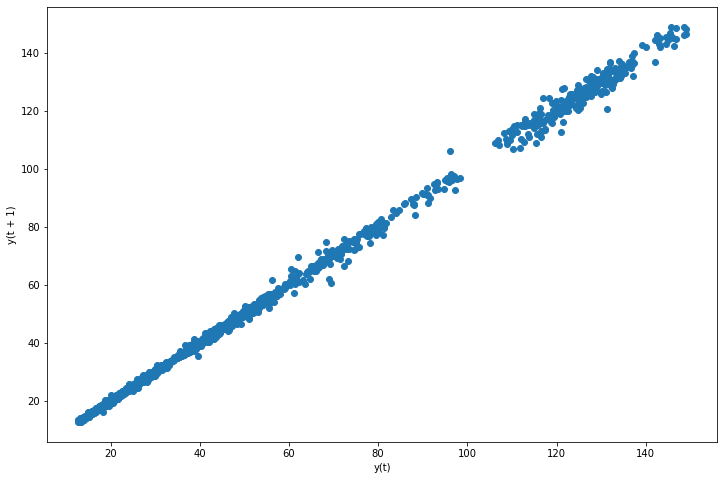

In [44]:
# loop through the symbols:
symbols = ['AAPL', 'AMZN']
pd.plotting.lag_plot(less_grouped.loc[less_grouped.Symbol == 'AAPL', 'Close'])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

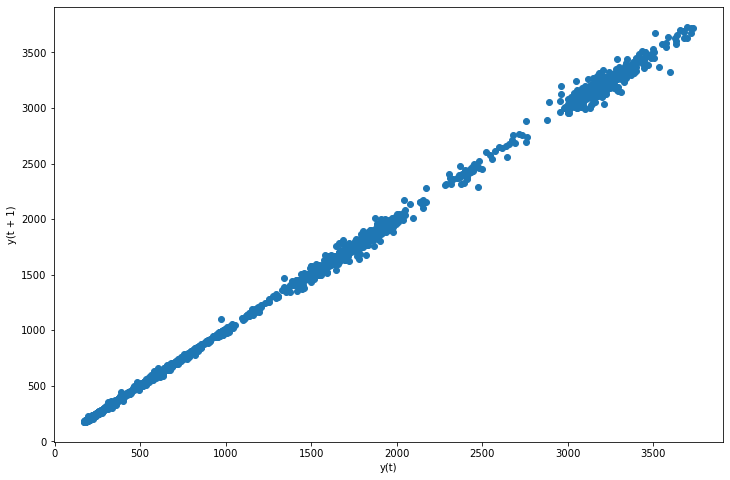

In [45]:
pd.plotting.lag_plot(less_grouped.loc[less_grouped.Symbol == 'AMZN', 'Close'])

## Return to AAPL Only Series - Create TREND data
 - We already have the closing prices and we have LAG functions for 2 days before, 3 days before, and 4 days before
 - We'll assign a trend for each of 3 days, where the trend is {1, -1}
 - The 3-day trend will sum the 3 days of trend and if it's positive, return 1, else -1

Create a few functions that we can apply at the row-level of the dataframe to create trends each year

In [46]:
# Create a function that outputs trend (-1 or 1)
def trend_set_1(row):
    if row['day_prev_close'] - row['min_2_close'] > 0:
        return 1
    else:
        return -1
    
def trend_set_2(row):
    if row['min_2_close'] - row['min_3_close'] > 0:
        return 1
    else:
        return -1
    
def trend_set_3(row):
    if row['min_3_close'] - row['min_4_close'] > 0:
        return 1
    else:
        return -1    

def trend_3_day(row):
    if (row.min_1_trend + row.min_2_trend + row.min_3_trend) > 0:
        return 1
    else:
        return -1

In [47]:
df_aapl['min_1_trend'] = df_aapl.apply(trend_set_1, axis = 1)
df_aapl['min_2_trend'] = df_aapl.apply(trend_set_2, axis = 1)
df_aapl['min_3_trend'] = df_aapl.apply(trend_set_3, axis = 1)

In [48]:
df_aapl['trend_3_day'] = df_aapl.apply(trend_3_day, axis = 1)
df_aapl.head()

,Date,Close,Year,day_prev_close,min_2_close,min_3_close,min_4_close,pct_close_change,Symbol,min_1_trend,min_2_trend,min_3_trend,trend_3_day
0,2011-08-01,14.169643,2011,NaN,NaN,NaN,NaN,NaN,AAPL,-1,-1,-1,-1
1,2011-08-02,13.889643,2011,14.169643,NaN,NaN,NaN,98.023945,AAPL,-1,-1,-1,-1
2,2011-08-03,14.020357,2011,13.889643,14.169643,NaN,NaN,100.941090,AAPL,-1,-1,-1,-1
3,2011-08-04,13.477500,2011,14.020357,13.889643,14.169643,NaN,96.128080,AAPL,1,-1,-1,-1
4,2011-08-05,13.343571,2011,13.477500,14.020357,13.889643,14.169643,99.006277,AAPL,-1,1,-1,-1


# Visualize Time-Series Data
- We can use pandas.plot on our df.
- We'll tell it that `x = 'Date'` and `y = 'Close`
- You'll se a legend that tells you the y-value

The simplest plot you can make is to show the closing stock price as a time series. Pandas DataFrames have built in plotting funtionality based on Matplotlib.

In [49]:
df.plot(x='Date', y='Close');

NameError: name 'df' is not defined

## Visualize the Trend on the Line


You can also embed the `trend_3_day` variable into the time series above. 
- The original plot has 10 years, so we are going to subset the data to just one month
- Use `start_date = '2018-06-01'` and `end_date = '2018-07-31'`
- Our x = 'Date' and y = 'Close'
- pandas.plot() allows you to use 'k--' for creating dotted lines
- On top of the line plot, we will create two scatter plots in matplotlib with the same x and y, one for positive trend in blue, and one for negative trend in red:
    - Scatter: 1
    - `color = 'b'`
    - `label = 'pos_trend'`
    - `data = (df.loc[df.trend_3_day == 1 & pd.to_datetime(df.Date).between(start_date, end_date)])`
    - Scatter: 2
    - `color = 'r'`
    - `label = 'neg_trend'`
    - `data = (df.loc[df.trend_3_day == -1 & pd.to_datetime(df.Date).between(start_date, end_date)])`
- plot the legend!

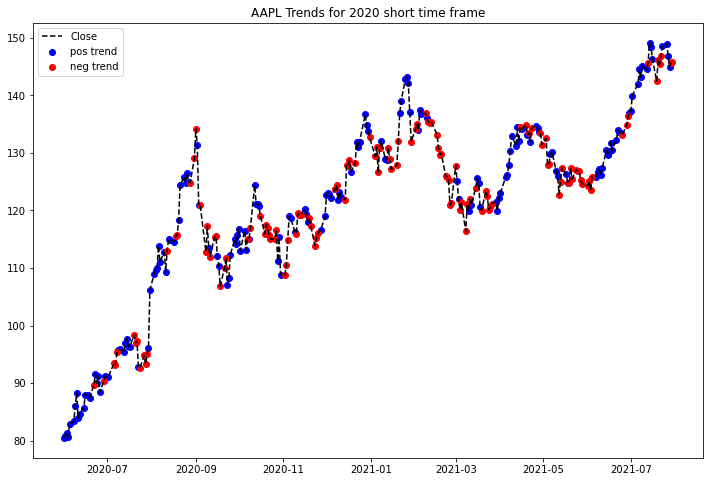

In [50]:
start_date = '2020-06-01'
end_date = '2021-07-31'

plt.plot(
    'Date', 'Close', 'k--',
    data = (
        df_aapl.loc[pd.to_datetime(df_aapl.Date).between(start_date, end_date)]
    )
)

plt.scatter(
    'Date', 'Close', color='b', label='pos trend', 
    data = (
        df_aapl.loc[(df_aapl.trend_3_day == 1) & pd.to_datetime(df_aapl.Date).between(start_date, end_date)]
    )
)

plt.scatter(
    'Date', 'Close', color='r', label='neg trend',
    data = (
        df_aapl.loc[(df_aapl.trend_3_day == -1) & pd.to_datetime(df_aapl.Date).between(start_date, end_date)]
    )
)
plt.title('AAPL Trends for 2020 short time frame')
plt.legend();

In [51]:
df_aapl.shape

(2517, 13)

## Build a Regression Model in Scikit-Learn

In this section you'll train a linear regression model to predict AAPL closing prices when given the previous day's closing price `day_prev_close` and the three day trend `trend_3_day`. A training set and test set are created by sequentially splitting the data after 2000 rows. 

In [61]:
df_aapl.head()

,Date,Close,Year,day_prev_close,min_2_close,min_3_close,min_4_close,pct_close_change,Symbol,min_1_trend,min_2_trend,min_3_trend,trend_3_day
0,2011-08-01,14.169643,2011,NaN,NaN,NaN,NaN,NaN,AAPL,-1,-1,-1,-1
1,2011-08-02,13.889643,2011,14.169643,NaN,NaN,NaN,98.023945,AAPL,-1,-1,-1,-1
2,2011-08-03,14.020357,2011,13.889643,14.169643,NaN,NaN,100.941090,AAPL,-1,-1,-1,-1
3,2011-08-04,13.477500,2011,14.020357,13.889643,14.169643,NaN,96.128080,AAPL,1,-1,-1,-1
4,2011-08-05,13.343571,2011,13.477500,14.020357,13.889643,14.169643,99.006277,AAPL,-1,1,-1,-1


## Manually Split Data into Test and Train Data
- The first 2000 rows will be our "train"
- That last 769 rows will be our hold-out / "test"

In [63]:
features = ['day_prev_close', 'trend_3_day']
target = 'Close'

X_train, X_test = df_aapl.loc[1:2000, features], df_aapl.loc[2000:, features]
y_train, y_test = df_aapl.loc[1:2000, target], df_aapl.loc[2000:, target]

## Instantiate a LinearRegression() object and call it `lr`

In [64]:
# Create linear regression object. Don't include an intercept,
# TODO
lr = linear_model.LinearRegression()

## Fit the Model 
- ### (Let the Optimization Algo Learn the Relationship between X and y)

In [65]:
# Train the model using the training set
lr.fit(X_train, y_train)

LinearRegression()

## Model Predictions

In [66]:
# Make predictions using the testing set
# TODO
preds = lr.predict(X_test)

## Model Validation

In [67]:
# Print the root mean squared error of your predictions
# TODO
print(np.sqrt(mean_squared_error(y_test, preds)))

2.1999751751624137


In [68]:
# Print the variance score (1 is perfect prediction)
# TODO
print(r2_score(y_test, preds))

0.994770673190528


### Plot the Predictions Against the Actuals to See How Well the Model Did

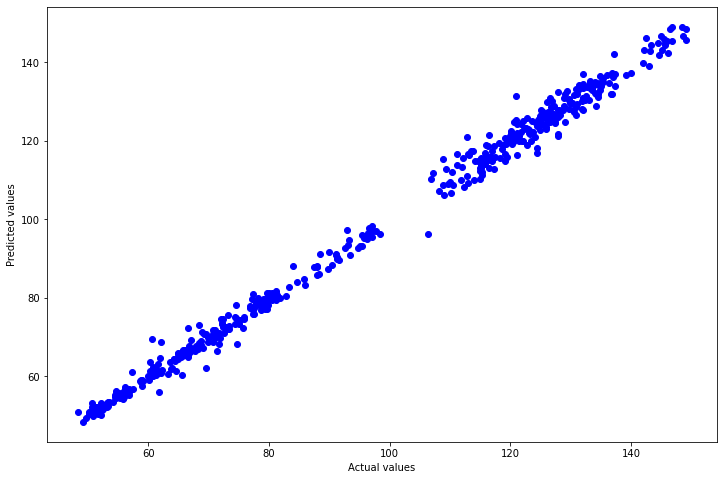

In [87]:
# Plot the predicted values against their corresponding true values
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.scatter(y_test, preds, color='blue');

The model's predictions are more or less in line with the truth.

In [75]:
print('Root Mean Squared Error: {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, X_test.day_prev_close))))

Root Mean Squared Error: 2.20


## More on Time-Series that Leads toward ARIMA models
- Stationary Data:
    - the statistical structure of the series is independent of time (the mean and variance don't change over time)
    - We find this visually through plots
    - We find this analytically through summary statistics. Check for significant differences in averages
    - We find whether the expectations of stationarity have been met or have been violated through statistical tests
    
- Converting trended data to "stationary"
    - Identify and remove trends and seasonal effects
    - First differences: Difference one time period from another (take the difference between two data points and plot)
    - Second differences:  This is commonly needed with data where growth is compounded each year such as GDP and stock prices. Exponentially growing prices require a second differencing.
    - You can double check the stationarity of your differenced data with the Augmented Dickey-Fuller test
    
- Why Stationarity is Important?
    - If your data is not stationary, which mean will you choose to represent your data?
    - Stationarity gives you a stable model with stable parameters that don't change over time.
    
- Important Concepts in Stationarity:
    - Trend
    - Seasonality: Data is affected by time of year (like ice cream and snow hats)
    - Cyclical Component: Measured over longer time horizons (need more than one year of data), tied to business cycle
    - Irregular (or residual) Component: Economic crashes, pandemics, weather storms: These effects are unpredictable but dramatic
    
- Stock prices are typically trending up or down, the mean and standard deviation changes over time
    - To make it stationary:
        - Difference stock prices to get daily, monthly or annual returns